In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load data

In [34]:
# Load data
psw_Amsterdam_raw = pd.read_csv('../../data/raw PSW df Amsterdam')
psw_Osdorp_raw = pd.read_csv('../../data/raw PSW df Osdorp-Midden')

In [35]:
# Drop unnecessary (for now)
psw_Ams_raw = psw_Amsterdam_raw.drop(['heading', 'label_is_temporary','pitch', 'zoom', 'label_id', 'gsv_panorama_id','canvas_x', 'canvas_y', 'canvas_width', 'street_edge_id', 'canvas_height', 'gsv_url', 'label_date', 'label_severity', 'neighborhood', 'label_description', 'user_id'], axis=1)
psw_Os_raw = psw_Osdorp_raw.drop(['heading', 'pitch', 'label_is_temporary', 'zoom', 'canvas_x', 'label_id','canvas_y','gsv_panorama_id', 'canvas_width', 'street_edge_id', 'canvas_height', 'gsv_url', 'label_date', 'label_severity', 'neighborhood', 'label_description', 'user_id'], axis=1)

In [36]:
# Create DF for each type of annotation
cross_Ams_dupes = psw_Ams_raw[(psw_Ams_raw['label_type'] == 'Crosswalk')]
curbs_Ams_dupes = psw_Ams_raw[(psw_Ams_raw['label_type'] == 'CurbRamp')]
mCurbs_Ams_dupes = psw_Ams_raw[(psw_Ams_raw['label_type'] == 'NoCurbRamp')]

cross_Os_dupes = psw_Os_raw[(psw_Os_raw['label_type'] == 'Crosswalk')]
curbs_Os_dupes = psw_Os_raw[(psw_Os_raw['label_type'] == 'CurbRamp')]
mCurbs_Os_dupes = psw_Os_raw[(psw_Os_raw['label_type'] == 'NoCurbRamp')]


## Remove non-validated data

In [37]:
# Only keep sufficiently validated rows
def validation(df):
    validated = df[(df['disagree_count'] < df['agree_count']) & 
                        ((df['disagree_count'] + df['notsure_count']) < df['agree_count']) &
                        ((df["agree_count"] != 0))]
    return validated

In [38]:
cross_Ams_val = validation(cross_Ams_dupes)
curbs_Ams_val = validation(curbs_Ams_dupes)
mCurbs_Ams_val = validation(mCurbs_Ams_dupes)

cross_Os_val = validation(cross_Os_dupes)
curbs_Os_val = validation(curbs_Os_dupes) 
mCurbs_Os_val = validation(mCurbs_Os_dupes)

## Remove duplicates

In [42]:
# Function to remove duplicates
def duplicates(df):
    # Sort df by geometry and agree count
    df_sorted = df.sort_values(by=['geometry', 'agree_count'], ascending=[True, False])
   
    # Group by geometry and aggregate the rows
    df_aggregated = df_sorted.groupby('geometry').agg({'attribute_id': 'first', 
                                                    'label_type': 'first',
                                                    'osm_street_id' : 'first',
                                                    'severity': 'first',
                                                    'is_temporary': 'first',
                                                    'image_capture_date': 'first',
                                                    'agree_count': 'first',
                                                    'disagree_count': 'first',
                                                    'notsure_count': 'first',
                                                    'label_tags':  lambda x: list(x)
                                                    }).reset_index()
    
    return df_aggregated

In [43]:
# Remove duplicates data
cross_Ams_noDupes = duplicates(cross_Ams_val)
curbs_Ams_noDupes = duplicates(curbs_Ams_val)
mCurbs_Ams_noDupes = duplicates(mCurbs_Ams_val)

cross_Os_noDupes = duplicates(cross_Os_val)
curbs_Os_noDupes = duplicates(curbs_Os_val)
mCurbs_Os_noDupes = duplicates(mCurbs_Os_val)


## Add point cloud file location

In [44]:
# Function for adding point cloud coordinate labels to df 
def add_PC_coordinates(PSW_df):

    coordinates = PSW_df['geometry']
    pc_coordinates = []

    for val in coordinates: 
        coordinates_str = val.replace("POINT (", "").replace(")", "")
        x_str, y_str = coordinates_str.split()
        x = int(float(x_str) / 50)
        y = int(float(y_str) / 50)
        pc_coordinates.append(f"filtered_{x}_{y}")
    
    PSW_df['pc_file_name'] = pc_coordinates

    return PSW_df

In [45]:
# Add point cloud file location to data
cross_Ams = add_PC_coordinates(cross_Ams_noDupes)
curbs_Ams = add_PC_coordinates(curbs_Ams_noDupes)
mCurbs_Ams = add_PC_coordinates(mCurbs_Ams_noDupes)

cross_Os = add_PC_coordinates(cross_Os_noDupes)
curbs_Os = add_PC_coordinates(curbs_Os_noDupes)
mCurbs_Os = add_PC_coordinates(mCurbs_Os_noDupes)

In [46]:
# Count annotations
print("Crossings total:", len(cross_Ams))
print("Curbs total:", len(curbs_Ams))
print("Missing curbs total:", len(mCurbs_Ams))
print("Crossings Osdorp:", len(cross_Os))
print("Curbs Osdorp:", len(curbs_Os))
print("Missing curbs Osdorp:", len(mCurbs_Os))

Crossings total: 786
Curbs total: 2514
Missing curbs total: 318
Crossings Osdorp: 106
Curbs Osdorp: 432
Missing curbs Osdorp: 18


In [52]:
# Merge dataframes
Ams_complete = pd.concat([cross_Ams, curbs_Ams, mCurbs_Ams])
Os_complete = pd.concat([cross_Os, curbs_Os, mCurbs_Os])

# Reset the index
Ams_complete = Ams_complete.reset_index(drop=True)
Os_complete = Os_complete.reset_index(drop=True)

In [53]:
# Add image capture year 
def image_capture(df):
    df['image_capture_date'] = pd.to_datetime(df['image_capture_date'])

    # Extract years from dates
    df['year'] = df['image_capture_date'].dt.year

    # Remove old column
    df = df.drop(['image_capture_date'], axis=1)

    return df

In [54]:
Ams_complete = image_capture(Ams_complete)
Os_complete = image_capture(Os_complete)

/anaconda/envs/myenv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


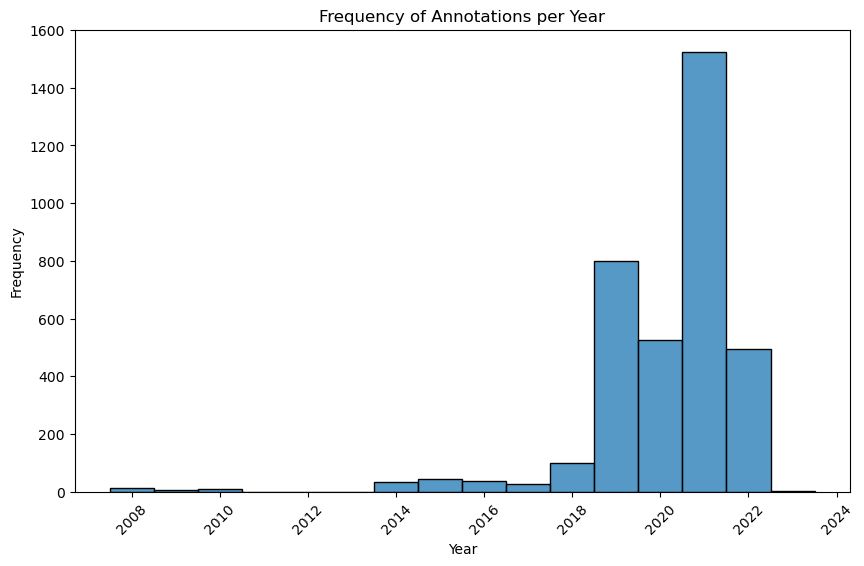

In [62]:
# Plot histogram using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=Ams_complete, x='year', discrete=True, kde=False)

# Set labels
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Frequency of Annotations per Year')
plt.xticks(rotation=45)

# Show plot
plt.show()

In [ ]:
# Ams_complete.to_csv("../../data/clean PSW df Amsterdam", index=False)
# Os_complete.to_csv("../../data/clean PSW df Osdorp-Midden", index=False)

## Create samples

In [ ]:
cross_Os.sample(15)

,geometry,label_type,severity,image_capture_date,agree_count,disagree_count,notsure_count,label_tags,year,pc_file_name
105,POINT (115110.08321337239 485093.3946249133),Crosswalk,2.0,2020-06-01,4,1,0,"[['paint fading'], [], []]",2020,filtered_2302_9701
1,POINT (114127.63708951736 486258.0807337353),Crosswalk,1.0,2021-04-01,3,0,0,[[]],2021,filtered_2282_9725
18,POINT (114278.344756028 485930.4257763769),Crosswalk,1.0,2020-09-01,3,0,0,"[[], []]",2020,filtered_2285_9718
66,POINT (114690.54887667744 485662.18049921555),Crosswalk,2.0,2021-08-01,4,0,0,"[['paint fading'], ['paint fading'], []]",2021,filtered_2293_9713
88,POINT (114893.32982334765 485711.0396593278),Crosswalk,2.0,2022-02-01,4,0,0,"[['paint fading'], [], ['paint fading'], ['pai...",2022,filtered_2297_9714
92,POINT (114952.22036180734 485189.75105075765),Crosswalk,1.0,2021-03-01,4,0,0,"[[], []]",2021,filtered_2299_9703
7,POINT (114230.73623496233 485951.61722338386),Crosswalk,1.0,2020-09-01,3,0,0,"[[], [], [], []]",2020,filtered_2284_9719
95,POINT (114979.03645890742 485071.1097912685),Crosswalk,2.0,2021-03-01,4,0,0,"[[], ['paint fading'], ['paint fading']]",2021,filtered_2299_9701
103,POINT (115017.91980055283 485062.305642575),Crosswalk,2.0,2021-03-01,3,0,0,"[[], ['paint fading'], []]",2021,filtered_2300_9701
89,POINT (114903.34703198547 485348.47065627965),Crosswalk,1.0,2021-03-01,4,0,0,"[[], [], [], [], [], [], [], ['paint fading']]",2021,filtered_2298_9706
